In [13]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Evaluation.Evaluator import EvaluatorHoldout
import matplotlib.pyplot as plt

In [14]:
URM = createURM()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/recsys2022DataReader.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [15]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

In [16]:
profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

In [17]:
block_size = int(len(profile_length) * 0.2)

In [6]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

In [7]:
recommender_object_dict = {}

In [8]:
# RP3beta
RP3beta = RP3betaRecommender(URM_train)
RP3beta.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
recommender_object_dict['RP3Beta'] = RP3beta

RP3betaRecommender: Similarity column 24507 (100.0%), 3583.54 column/sec. Elapsed time 6.84 sec


# Interactions

In [20]:
list_group_interactions = [[0, 20], [21, 46], [48, max(interactions)]]
MAP_recommender_per_group_int = {}

for group_id in range(0, 3):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions))
                      if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_int:
            MAP_recommender_per_group_int[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_int[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 9096, average p.len 16.90, median 17.0, min 5, max 20
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32533 Users
EvaluatorHoldout: Processed 8463 (100.0%) in 4.02 sec. Users per second: 2107
Group 1, #users in group 23855, average p.len 30.19, median 29.0, min 21, max 46
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 17774 Users
EvaluatorHoldout: Processed 23587 (100.0%) in 10.15 sec. Users per second: 2323
Group 2, #users in group 8296, average p.len 79.91, median 65.0, min 48, max 1206
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33333 Users
EvaluatorHoldout: Processed 8295 (100.0%) in 4.62 sec. Users per second: 1795


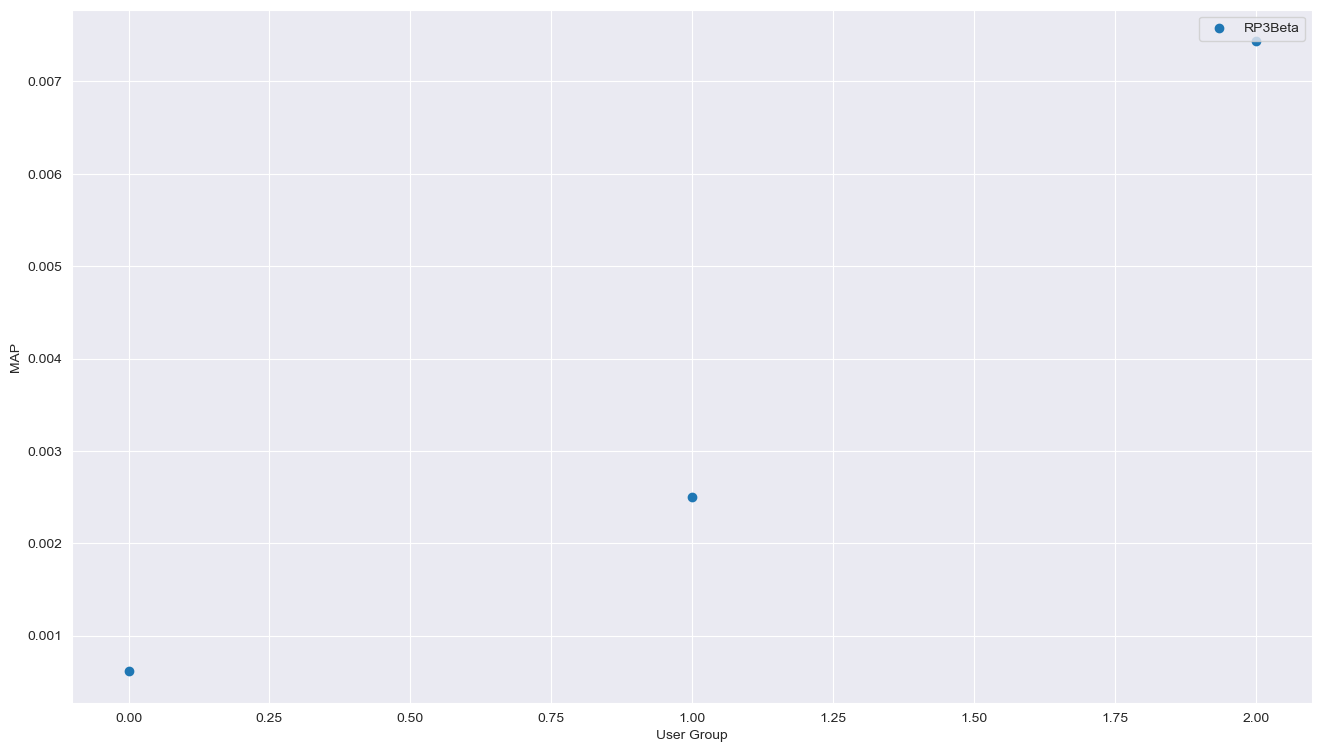

RP3Beta [0.0006139282291356018, 0.002504138680104256, 0.00743608216845108]


In [21]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_int[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# 5 Blocks

In [18]:
MAP_recommender_per_group_block = {}

for group_id in range(0, 5):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_block:
            MAP_recommender_per_group_block[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_block[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 8325, average p.len 16.61, median 17.0, min 5, max 20
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 7724 (100.0%) in 3.98 sec. Users per second: 1943
Group 1, #users in group 8325, average p.len 22.66, median 23.0, min 20, max 25
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 8118 (100.0%) in 3.97 sec. Users per second: 2047
Group 2, #users in group 8325, average p.len 28.73, median 29.0, min 25, max 33
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 8243 (100.0%) in 4.07 sec. Users per second: 2027
Group 3, #users in group 8325, average p.len 38.92, median 38.0, min 33, max 47
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test int

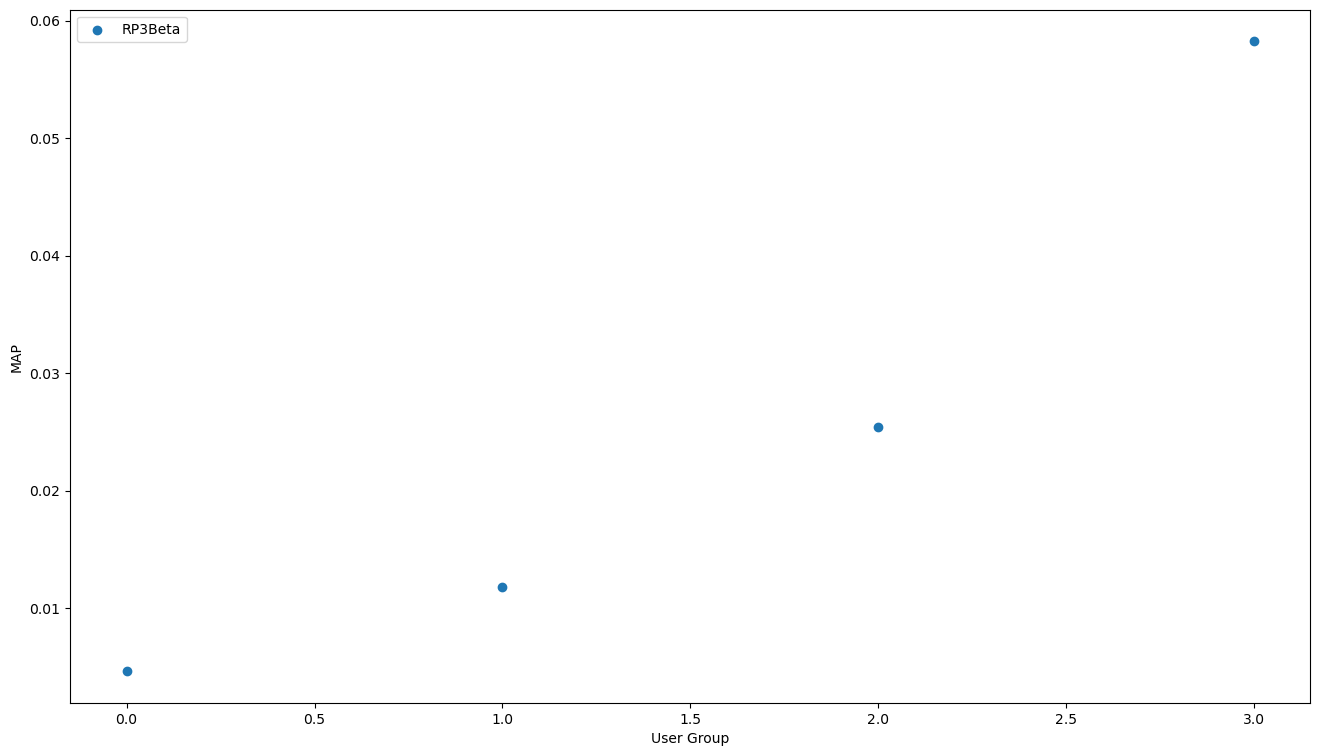

RP3Beta [0.004632526682593662, 0.011767411805798022, 0.025445596505822406, 0.058247771432232635]


In [12]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_block[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# 5 blocks

In [13]:
MAP_recommender_per_group_block = {}
block_size = int(len(profile_length) * 0.2)

for group_id in range(0, 5):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_block:
            MAP_recommender_per_group_block[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_block[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 8325, average p.len 16.61, median 17.0, min 5, max 20
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 7709 (100.0%) in 5.05 sec. Users per second: 1528
Group 1, #users in group 8325, average p.len 22.66, median 23.0, min 20, max 25
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 8103 (100.0%) in 6.36 sec. Users per second: 1274
Group 2, #users in group 8325, average p.len 28.73, median 29.0, min 25, max 33
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 8250 (100.0%) in 5.60 sec. Users per second: 1473
Group 3, #users in group 8325, average p.len 38.92, median 38.0, min 33, max 47
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test int

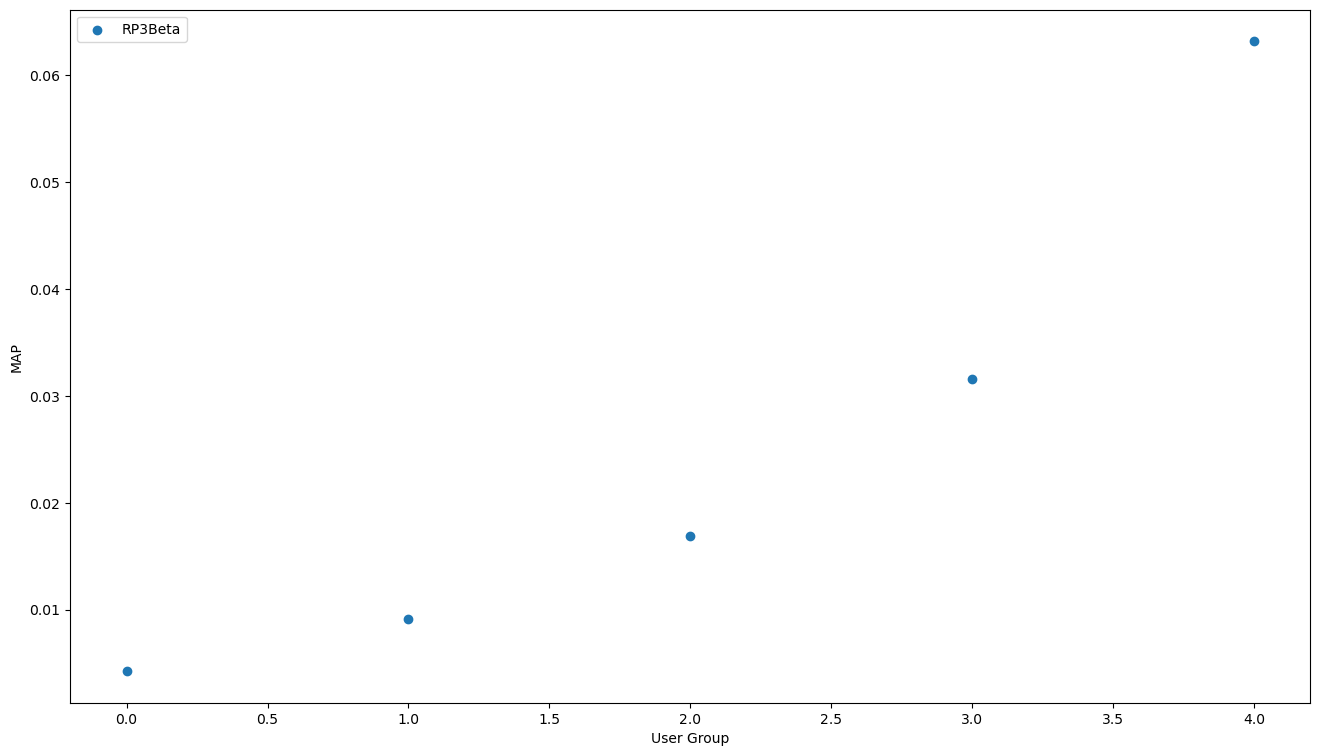

RP3Beta [0.004244502920725542, 0.009123291589044987, 0.016884521404521305, 0.031573308346084905, 0.06318031841365232]


In [14]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_block[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# Interactions 2

In [15]:
list_group_interactions = [[0, 109], [110, 149], [150, max(interactions)]]
MAP_recommender_per_group_int = {}

for group_id in range(0, 3):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions))
                      if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_int:
            MAP_recommender_per_group_int[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_int[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 40536, average p.len 33.75, median 28.0, min 5, max 109
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1093 Users
EvaluatorHoldout: Processed 39607 (100.0%) in 26.47 sec. Users per second: 1496
Group 1, #users in group 613, average p.len 125.31, median 124.0, min 110, max 149
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 41016 Users
EvaluatorHoldout: Processed 613 (100.0%) in 1.94 sec. Users per second: 315
Group 2, #users in group 480, average p.len 229.00, median 188.0, min 150, max 1206
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 41149 Users
EvaluatorHoldout: Processed 480 (100.0%) in 1.79 sec. Users per second: 268


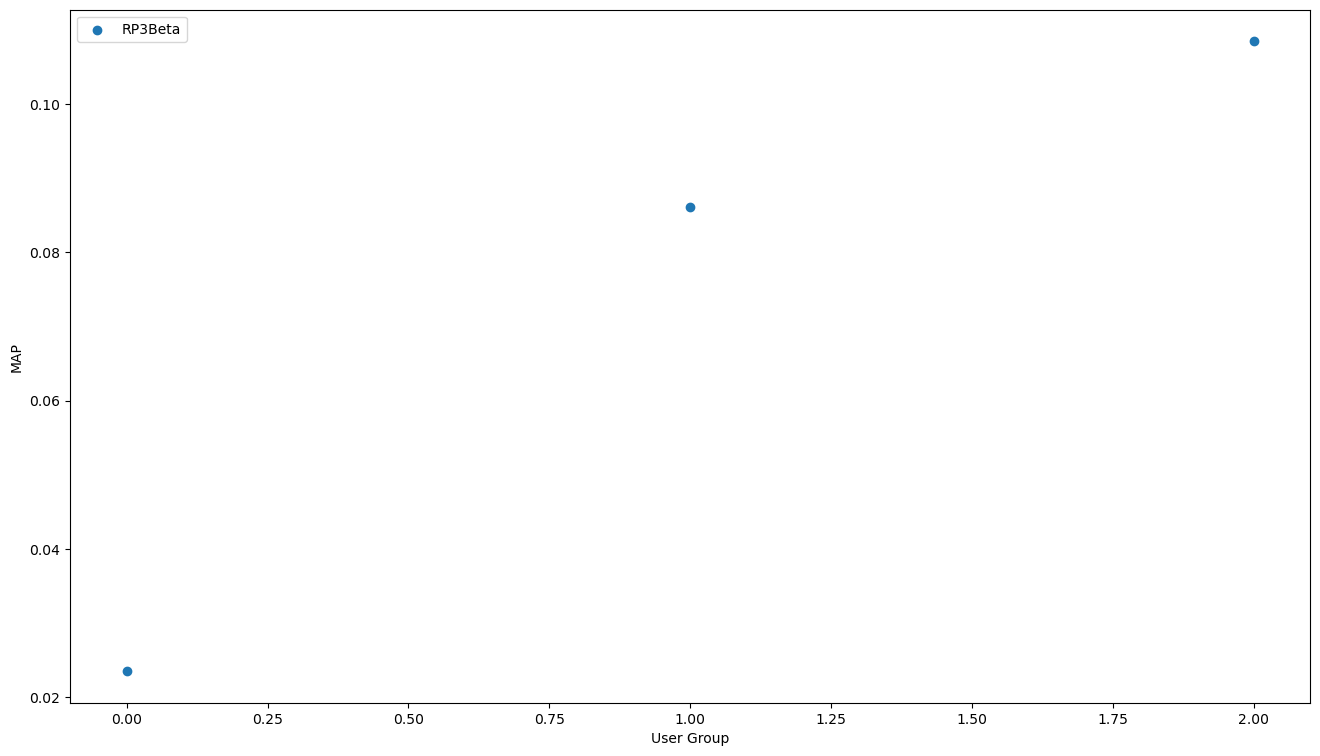

RP3Beta [0.023487581961020538, 0.08611046376136104, 0.10848850859788367]


In [16]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_int[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))